In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import pickle
import xgboost as xgb
from sklearn.metrics import precision_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils.class_weight import compute_sample_weight

from sklearn.metrics import accuracy_score
pd.set_option('display.max_columns', 100)

# Loading data
Setting up the target coloumn and make ready for train test. The results are not balanced. Champions Leageue teams win most of their domestic league matches too. 

In [2]:
df = pickle.load(open('clean_df.pkl', 'rb'))
df = df.sort_values("date")
df=df.reset_index(drop=True)
df['venue'] = df['venue'].apply(lambda x:'Away' if x =='Neutral' else x) # Adding neutral ground to away.
df['target'] = df['result']. apply(lambda x: 1 if x=='W' else (0 if x=='L' else 2) )
df = df.loc[df['comp']=='Champions Lg'].copy() # Only champions league matches.
print(df['target'].value_counts())
print(df.shape)

1    282
0    258
2    143
Name: target, dtype: int64
(683, 71)


### Defining functions
- train_test
- rolling averages
- infer

For  Feature Engineering

In [3]:
def rolling_averages(group, cols, new_cols,h): # Feature Engineering by rolling averages, h is the horizon for this 3 games, 4 games etc.
    group = group.sort_values("date")
    rolling_stats = group[cols].rolling(h,closed="left").mean() # closed = left -> to avoid data leakage from future matches 5 matches
    group[new_cols] = rolling_stats
    group = group.dropna(subset = new_cols)
    return group

In [4]:
def rolling_constructor(cols,data,h): #constructs a rolling avergae data from using the rolling avergae function. Grouping by team to get the latest average stats.
    new_cols = [f"{c}_rolling" for c in cols] # add_rolling to column names
    df_rolling = data.groupby('team').apply(lambda x: rolling_averages(x,cols, new_cols, h))
    df_rolling = df_rolling.droplevel('team')
    return df_rolling, new_cols

In [5]:
def train_test(model, data, features, *args): # Function to tran and test, returns fitted model
    train = data[data['date']< "2022-6-15"] # Data in order of date use 70% for training
    test = data[data['date']> "2022-6-15"]

    if 'sample_weight' in args: #get sample weights in case using xgboost
        sample_weights = compute_sample_weight(
        class_weight='balanced',
        y=train['target'] #provide your own target name
        )
        #print(sample_weights)
        
        model.fit(train[features],train['target'],sample_weight=sample_weights )
    else:
        model.fit(train[features],train['target'])

    predictions = model.predict(test[features])
    combined = pd.DataFrame(dict(actual=test["target"], predicted=predictions))
    print(pd.crosstab(index=combined["actual"], columns=combined["predicted"]))
    precision_weight = precision_score(test["target"], predictions, average = 'weighted')
    precision_raw = precision_score(test["target"], predictions, average = None)

    fig,ax = plt.subplots(1,2, figsize = (20,10))
    ConfusionMatrixDisplay.from_estimator(model, test[features],
                                          test["target"], display_labels=['lost','won','drew'],
                                          cmap=plt.cm.Blues, normalize='true', ax =ax[0])

    
    imp = model.feature_importances_
    importance = pd.Series(data=imp,
                            index=  features)
    # Sort importances
    importances_sorted = importance.sort_values()
    # Draw a horizontal barplot of importances_sorted
    importances_sorted.plot(kind='barh', color='blue', ax = ax[1])
    plt.title('Features Importances')
    plt.show()

    precision_weight = precision_score(test["target"], predictions, average = 'weighted')
    precision_raw = precision_score(test["target"], predictions, average = None)

    print('The weighted percision is',precision_weight)
    print('The raw percision is: ',precision_raw)

    return combined, precision_weight, precision_raw, model

Procedure for inference:
- Get the features and split in two based on if they are for the home team or opposing team (f_h and f_opp)
- Get the latest match of the team in the dataframe, and select the features orm the hoe team.
- We need ot construct th eopposing team sub-dataframe to feed for inference. We need to now select the opposing team as home team (like above), change the feature names and take the "_opp" out, and find out the features for the opposing team. We then need to add those in the place of the opposing team features. 
- This way when we flip the teams, the opposing and home teams will be flipped and we would not make a mistake again. 

In [6]:
def infer(selected_team,selected_opponent, v_code, data, model,features): #inference function, returns 0, 1, 2 for loss, win and draw
    # split the features to home and opposing
    f_h = [f for f in features if "_opp" not in f] #Home team features
    f_opp = [f for f in features if "_opp" in f] #Opposing team features
    # Note that the opposing team features, for inference have to be the team features where the team is the opposing team.
    f_opp_p = [s.replace('_opp','') for s in f_opp] #opposing team features processed.
    ## Setting up the data to be fed into the model.
    hm_df = data[data['team'] == selected_team].tail(1) # get the last game row for the home team. It has the latest rolling stats.
    hm_df = hm_df[f_h].copy()
    # Get the stats for th eopposing team
    op_df = data[data['team'] == selected_opponent].tail(1) # Get the last game for the selected opponent, latest rolling stats
    op_df = op_df[f_opp_p].copy()
    # construcing the inference dataframe
    infer_df = hm_df
    infer_df[f_opp] = op_df.values #Placing the values we extracted for the opposing team under the correct column names in the infer dataframe
    infer_df['opp_code'] = int(data[data['opponent']==selected_opponent]['opp_code'].head(1)) # Adding the correct opp_code 
    infer_df['venue_code'] = v_code # adding the correct venue code (home away, 1,0)
    print(infer_df)
    inference = model.predict(infer_df[features])
    return inference

## First model

predicted   0   1   2
actual               
0          45  22  18
1          43  34  14
2          19  12  10


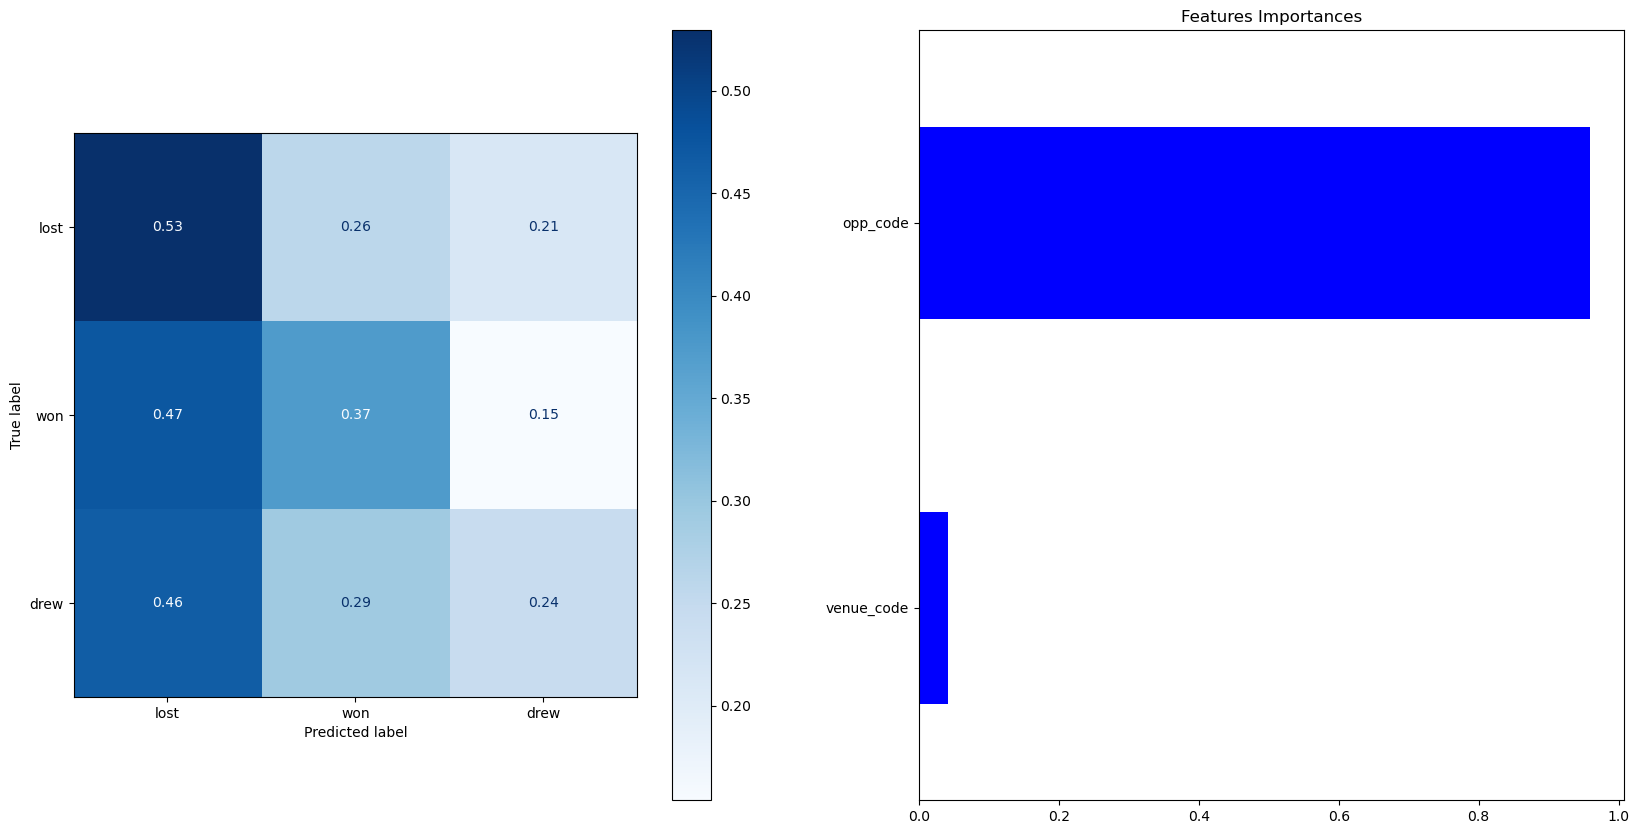

The weighted percision is 0.4193989323193854
The raw percision is:  [0.42056075 0.5        0.23809524]


In [7]:
predictors = ["venue_code", "opp_code"] # initial predictors 

rf = RandomForestClassifier(n_estimators=1000, min_samples_split=3,
                           class_weight='balanced',  random_state=1)
combined, precision_weight, precision_raw, rf = train_test(rf,df,predictors)

### Feature Engineering using rollaing averages form the previous games

predicted   0   1  2
actual              
0          43  17  3
1          33  36  5
2          20   8  2


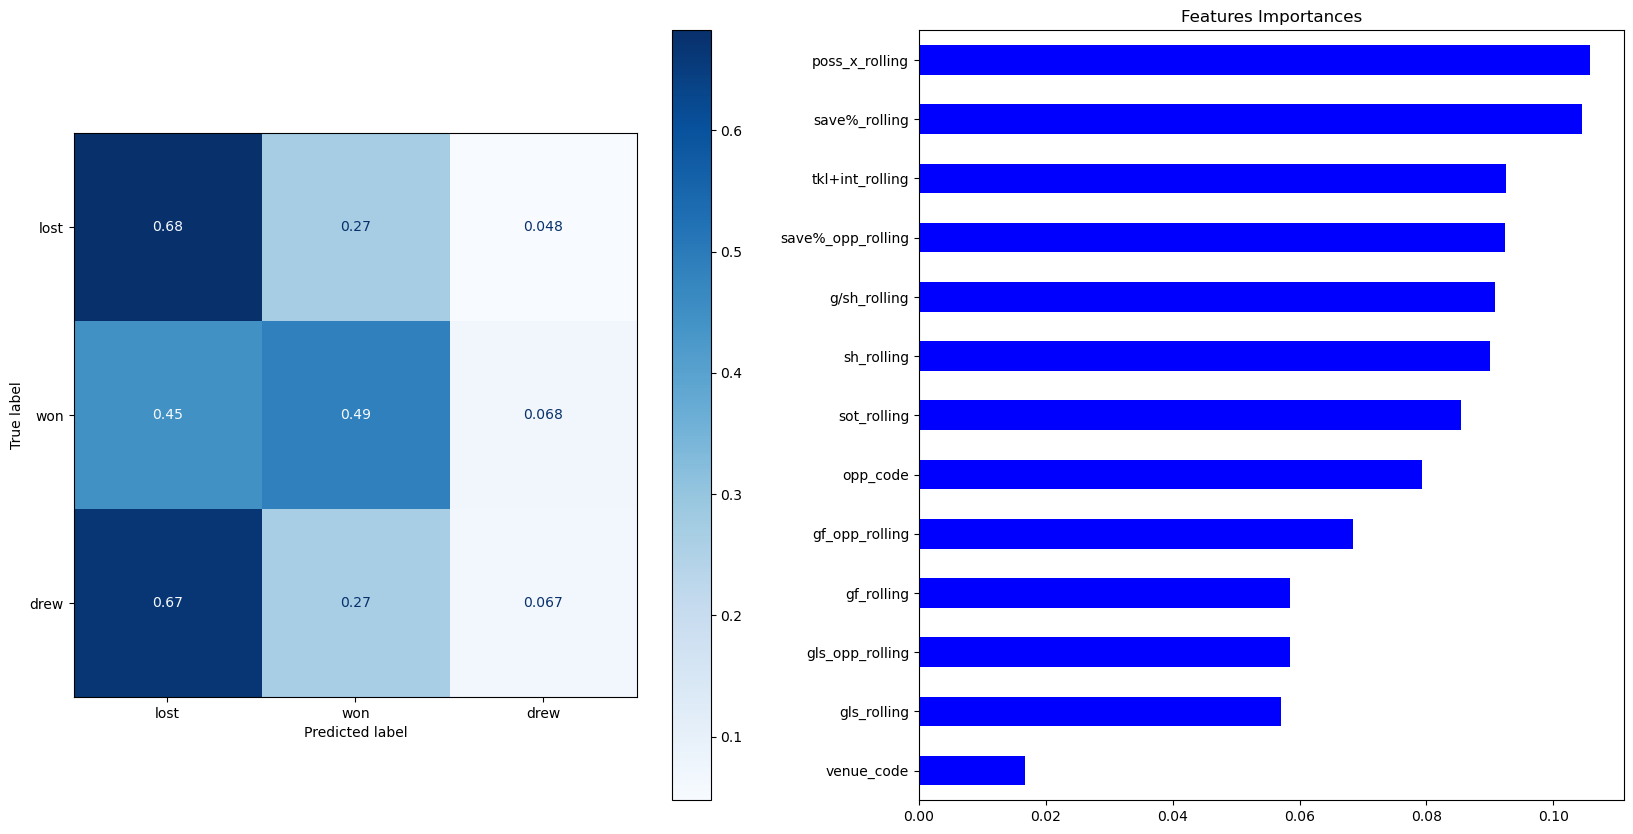

The weighted percision is 0.46641246196132324
The raw percision is:  [0.44791667 0.59016393 0.2       ]


In [8]:
cols = ['gls','gls_opp','gf','gf_opp','sh', 'sot','g/sh','save%','save%_opp','tkl+int','poss_x'] # Choosing based on domain knowledge.
df_rolling, new_cols = rolling_constructor(cols, df, 5)
rf = RandomForestClassifier(n_estimators=1000, min_samples_split=3,
                           class_weight='balanced',  random_state=1)
combined, precision_weight, precision_raw, rf = train_test(rf,df_rolling,predictors + new_cols)

In [9]:
selected_team = 'Chelsea' #input("Select Team ")
selected_opponent = 'Krasnodar' # input("Select Op_Team ")
v_code = 1; #input('v code 1 or 0')

inference = infer(selected_team,selected_opponent,v_code,df_rolling,rf,predictors+new_cols)
print(inference)

      venue_code  opp_code  gls_rolling  gf_rolling  sh_rolling  sot_rolling  \
3486           1       213          1.8         1.8        16.4          6.4   

      g/sh_rolling  save%_rolling  tkl+int_rolling  poss_x_rolling  \
3486         0.118          76.66             23.0            59.8   

      gls_opp_rolling  gf_opp_rolling  save%_opp_rolling  
3486              1.0             1.0              80.96  
[1]


More features

predicted   0   1  2
actual              
0          38  18  7
1          37  34  3
2          20   8  2


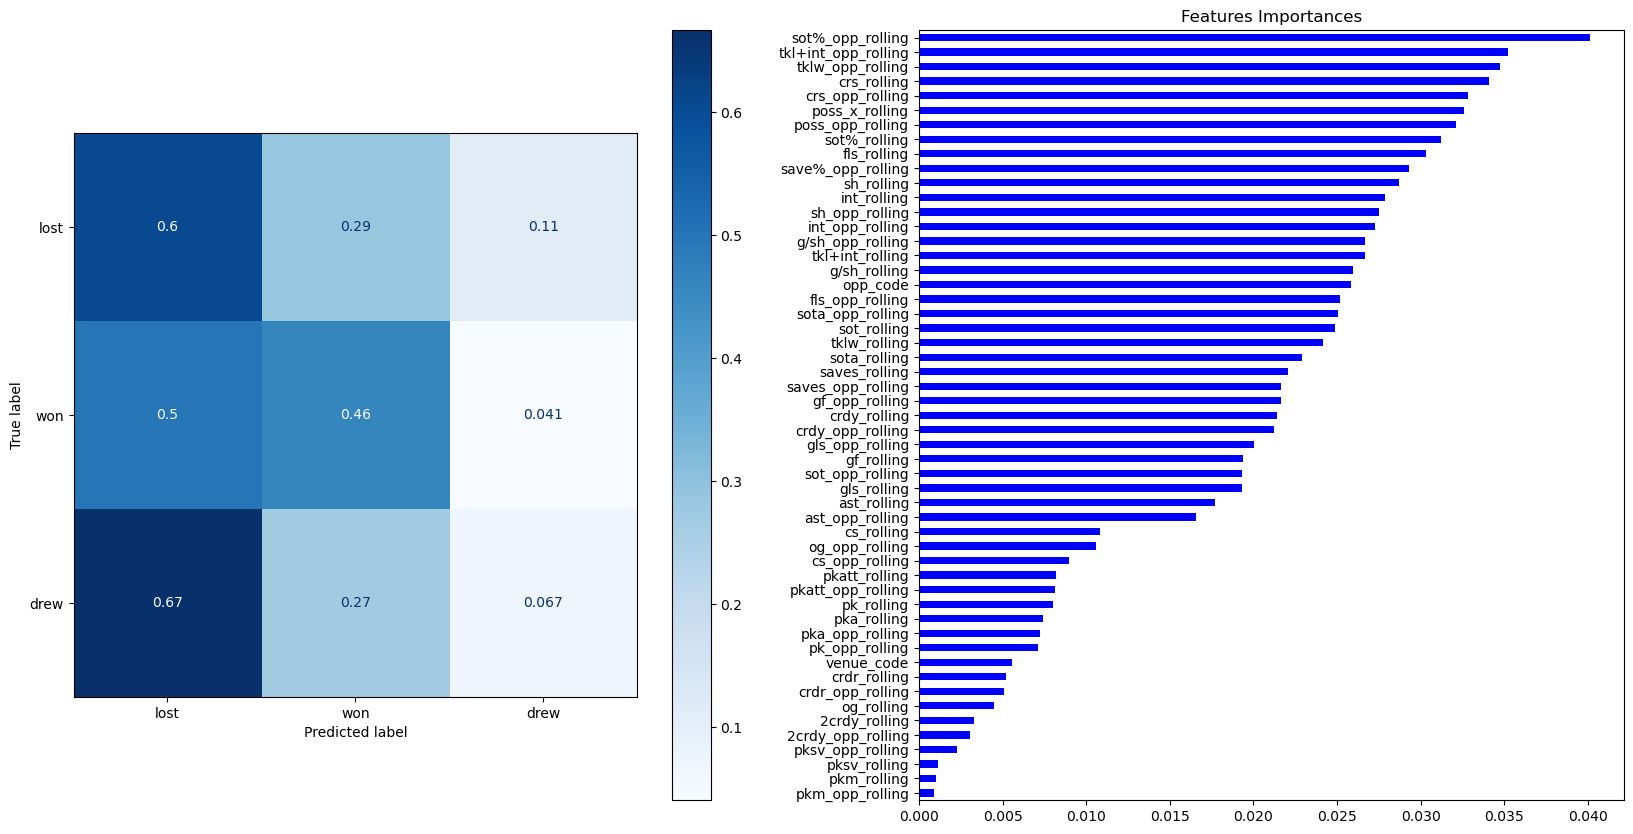

The weighted percision is 0.43193612774451096
The raw percision is:  [0.4        0.56666667 0.16666667]


In [10]:
cols = ['gf',
       'gls', 'sh', 'sot', 'sot%', 'g/sh', 'pk', 'pkatt', 'gf_opp', 'gls_opp',
       'sh_opp', 'sot_opp', 'sot%_opp', 'g/sh_opp', 'pk_opp', 'pkatt_opp',
       'sota', 'saves', 'cs', 'pka', 'pksv', 'pkm', 'sota_opp', 'saves_opp',
       'save%_opp', 'cs_opp', 'pka_opp', 'pksv_opp', 'pkm_opp', 'ast',
       'ast_opp', 'crs', 'crs_opp', 'tklw', 'int', 'tkl+int', 'tklw_opp',
       'int_opp', 'tkl+int_opp', 'poss_x', 'poss_opp', 'crdy', 'crdr', '2crdy',
       'fls', 'og', 'crdy_opp', 'crdr_opp', '2crdy_opp', 'fls_opp', 'og_opp',
       ]

df_rolling, new_cols = rolling_constructor(cols, df, 5)
rf = RandomForestClassifier(n_estimators=1000, min_samples_split=3,
                           class_weight='balanced',  random_state=1)
combined, precision_weight, precision_raw, rf = train_test(rf,df_rolling,predictors + new_cols)

In [11]:
df.team.unique()

array(['Red Bull Salzburg', 'Midtjylland', 'Krasnodar', 'Dynamo Kyiv',
       'Olympiacos', 'Ferencvaros', 'Sevilla', 'Dortmund', 'Juventus',
       'Rennes', 'Istanbul Basaksehir', 'Barcelona', 'Manchester United',
       'Lazio', 'Club Brugge', 'Paris Saint Germain', 'Chelsea',
       'RB Leipzig', 'Zenit', 'Monchengladbach', 'Liverpool', 'Marseille',
       'Bayern Munich', 'Atletico Madrid', 'Atalanta', 'Porto',
       'Manchester City', 'Lokomotiv Moscow', 'Real Madrid', 'Ajax',
       'Shakhtar Donetsk', 'Internazionale', 'Sheriff Tiraspol',
       'Young Boys', 'Benfica', 'Villarreal', 'Sporting CP', 'Besiktas',
       'Milan', 'Wolfsburg', 'Lille', 'Viktoria Plzen', 'Dinamo Zagreb',
       'FC Copenhagen', 'Rangers', 'Celtic', 'Maccabi Haifa',
       'Tottenham Hotspur', 'Bayer Leverkusen', 'Napoli',
       'Eintracht Frankfurt'], dtype=object)

## XGBoost

In [12]:
#Using minmax scaling to prepare for XGBoost. 
df_rolling[new_cols] = (df_rolling[new_cols]-df_rolling[new_cols].min())/(df_rolling[new_cols].max()-df_rolling[new_cols].min())

predicted   0   1   2
actual               
0          37  18   8
1          37  20  17
2          19   3   8


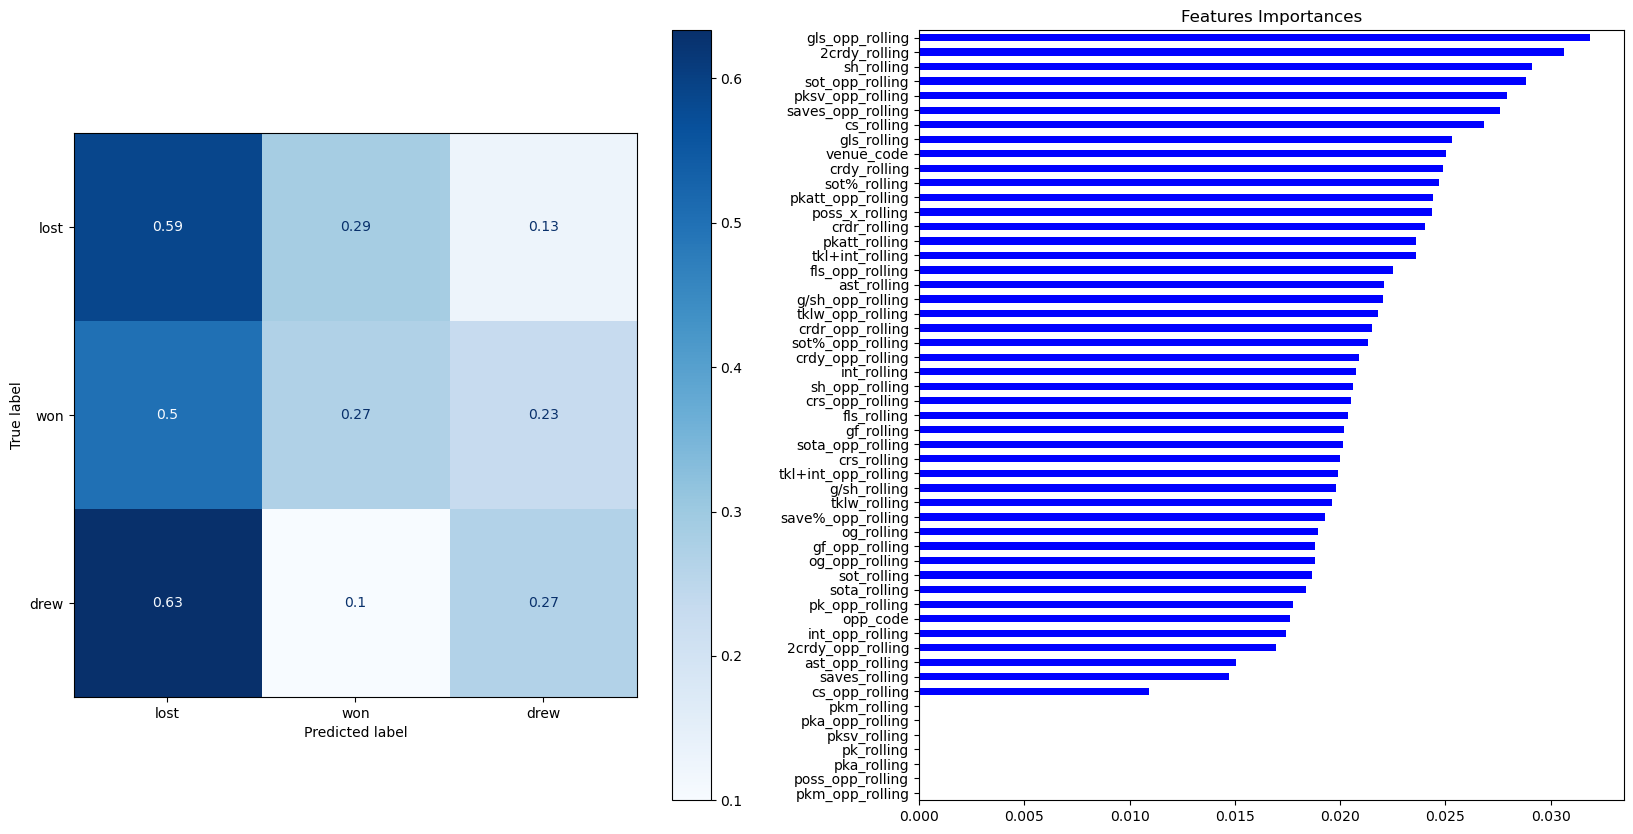

The weighted percision is 0.40978924776867837
The raw percision is:  [0.39784946 0.48780488 0.24242424]


In [13]:
#XGBClassifier default parameters are not available without fitting the model
XGB_model = xgb.XGBClassifier(verbosity = 0,
                              objective='reg:logistic',
                              num_class = 3,
                              booster='gbtree',
                              eta = 0.1,
                              eval_metric='mlogloss',
                              max_depth = 2,
                              max_delta_step = 10,
                              subsample = 0.1,
                              reg_lambda = 1.1,
                              reg_alpha = 0.6,
                              tree_method = 'exact',
                              )

combined, precision_weight, precision_raw, XGB_model = train_test(XGB_model,df_rolling, predictors + new_cols, 'sample_weight')

In [14]:
from itertools import compress

boolean = np.array(XGB_model.feature_importances_ >0.02)
imp = XGB_model.feature_importances_

trimmed_features =list(compress(imp, boolean))


predicted   0   1   2
actual               
0          34  16  13
1          39  19  16
2          21   5   4


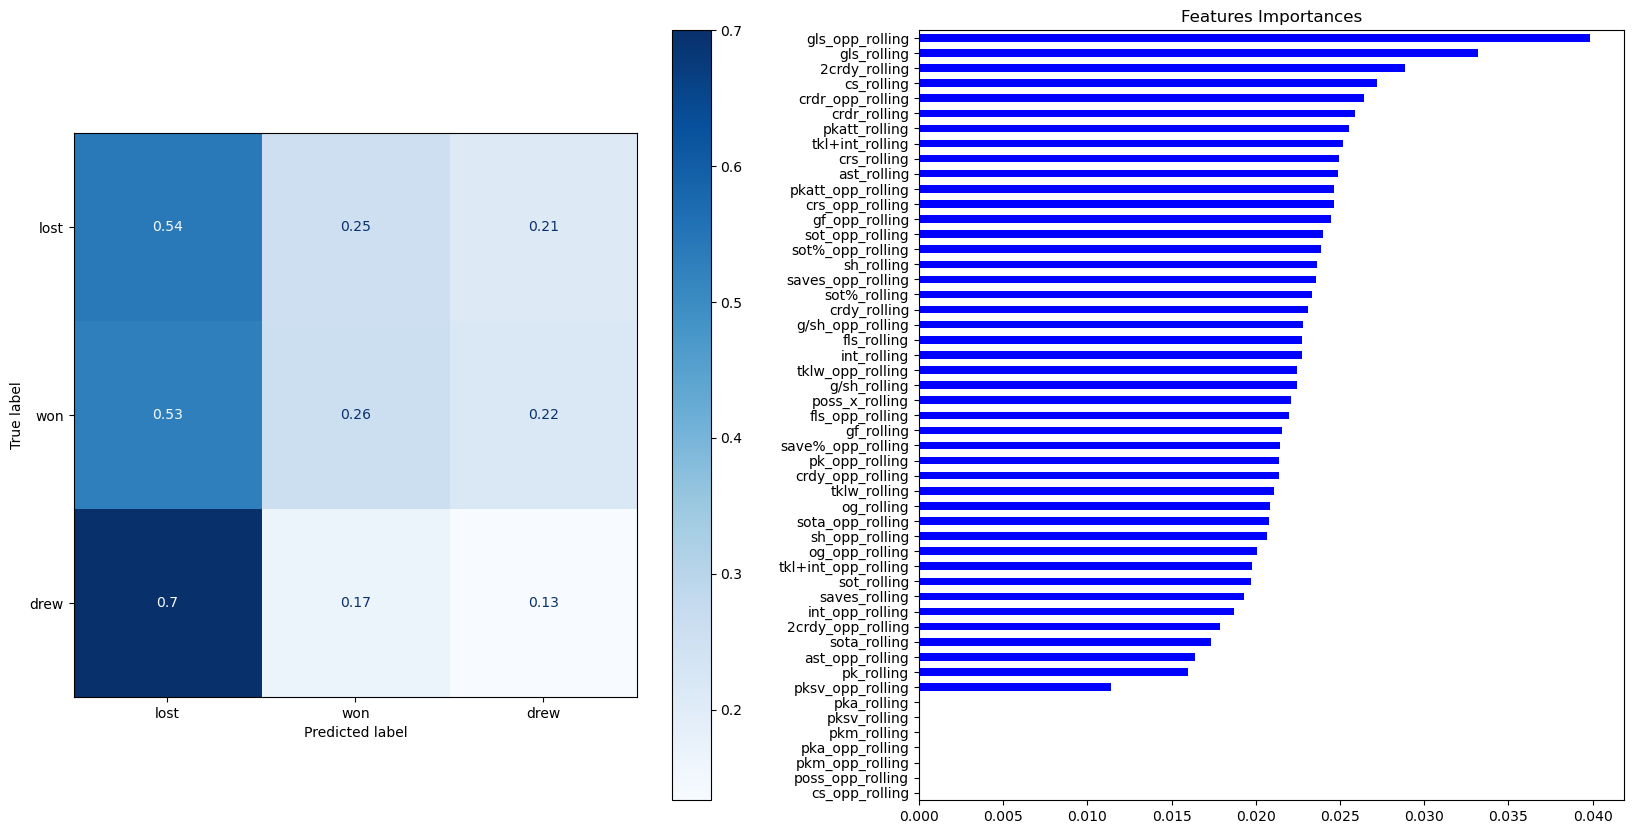

The weighted percision is 0.36870417771806485
The raw percision is:  [0.36170213 0.475      0.12121212]


In [15]:
#XGBClassifier default parameters are not available without fitting the model
XGB_model = xgb.XGBClassifier(verbosity = 0,
                              objective='reg:logistic',
                              num_class = 3,
                              booster='gbtree',
                              eta = 0.1,
                              eval_metric='mlogloss',
                              max_depth = 2,
                              max_delta_step = 10,
                              subsample = 0.1,
                              reg_lambda = 1.1,
                              reg_alpha = 0.6,
                              tree_method = 'exact',
                              )

combined, precision_weight, precision_raw, XGB_model = train_test(XGB_model,
                                                                  df_rolling,
                                                                  new_cols,
                                                                  'sample_weight')

In [16]:
sorted_idx = XGB_model.feature_importances_.argsort()
imp = pd.DataFrame(XGB_model.feature_importances_, index = XGB_model.feature_names_in_)
trim_features = list(imp[imp[0]>0.02].index)


predicted   0   1   2
actual               
0          35  15  13
1          38  18  18
2          23   4   3


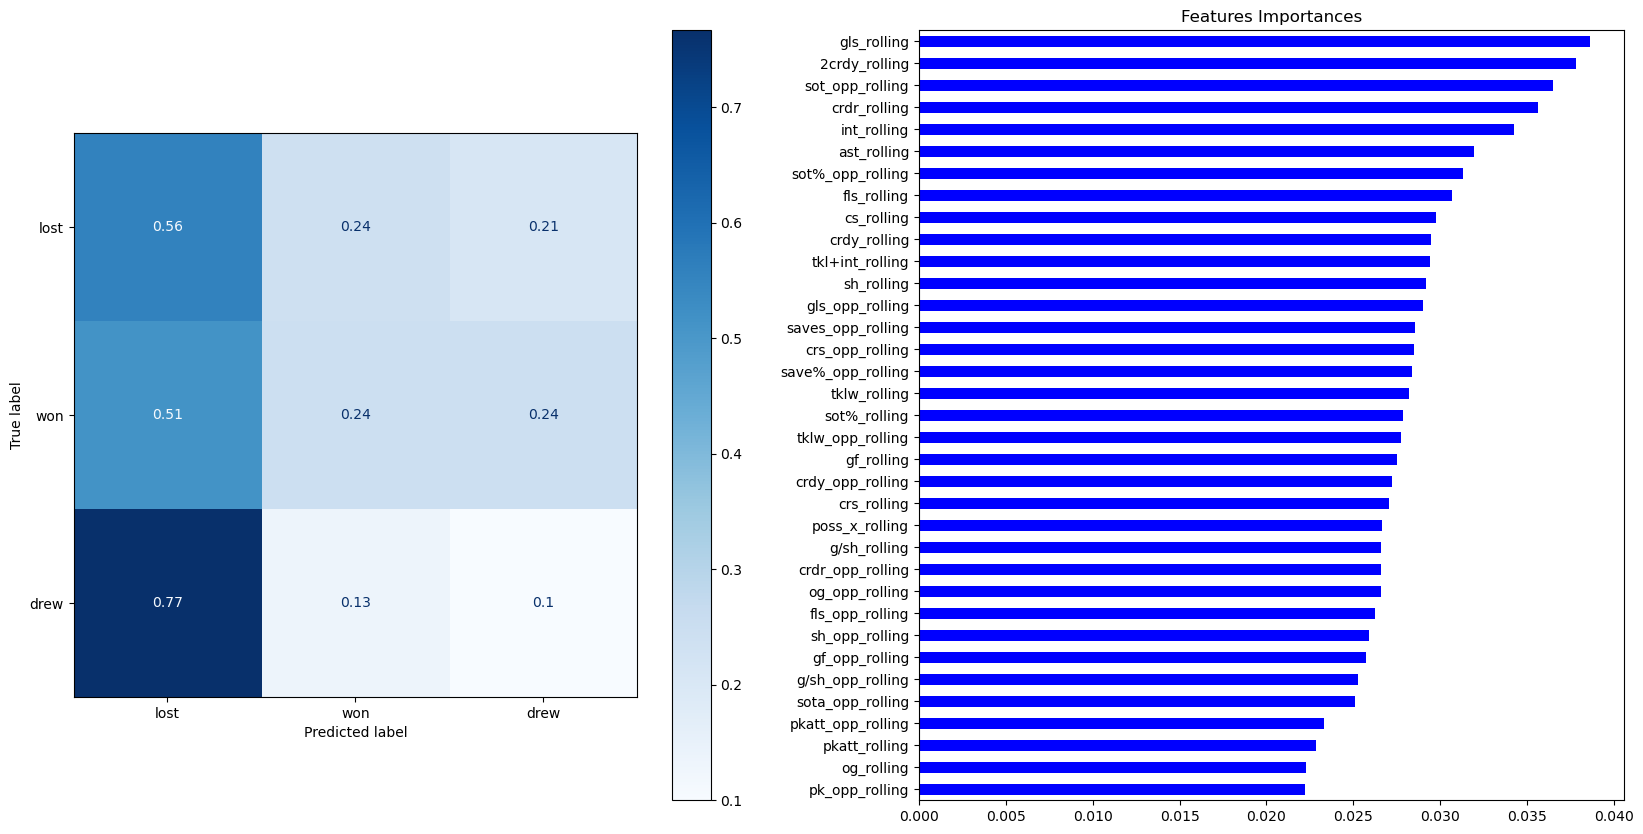

The weighted percision is 0.3689569390630504
The raw percision is:  [0.36458333 0.48648649 0.08823529]


In [17]:
#XGBClassifier default parameters are not available without fitting the model
XGB_model = xgb.XGBClassifier(verbosity = 0,
                              objective='multi:softmax',
                              num_class = 3,
                              booster='gbtree',
                              eta = 0.1,
                              eval_metric='mlogloss',
                              max_depth = 2,
                              max_delta_step = 10,
                              subsample = 0.1,
                              reg_lambda = 1.1,
                              reg_alpha = 0.6,
                              tree_method = 'exact',
                              )

combined, precision_weight, precision_raw, XGB_model = train_test(XGB_model,
                                                                  df_rolling,
                                                                  trim_features,
                                                                  'sample_weight')